<a href="https://colab.research.google.com/github/EdithOroche/IA/blob/main/Generaci%C3%B3n_de_Im%C3%A1genes_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Generativa Adversaria Convolucional Profunda
## DCGAN - Deep Convolutional Generative Adversarial Network

## ¿Qué son las GAN?
Las [redes generativas adversarias](https://arxiv.org/abs/1406.2661) (GAN) son una de las ideas más interesantes de la informática actual. Se entrenan dos modelos simultáneamente mediante un proceso adversario. Un *generador* («el artista») aprende a crear imágenes que parecen reales, mientras que un *discriminador* («el crítico de arte») aprende a distinguir las imágenes reales de las falsas.

![Diagrama de un generador y un discriminador](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

Durante el entrenamiento, el *generador* mejora progresivamente en la creación de imágenes que parecen reales, mientras que el *discriminador* mejora en su capacidad para distinguirlas. El proceso alcanza el equilibrio cuando el *discriminador* ya no puede distinguir las imágenes reales de las falsas.

![Segundo diagrama de un generador y un discriminador](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

Este cuaderno muestra este proceso en el conjunto de datos MNIST. La siguiente animación muestra una serie de imágenes producidas por el *generador* mientras se entrenaba durante 50 épocas. Las imágenes comienzan como ruido aleatorio y, con el tiempo, se parecen cada vez más a dígitos escritos a mano.

![ejemplo de resultado](https://tensorflow.org/images/gan/dcgan.gif)

Para obtener más información sobre las GAN, consulte el curso [Introducción al aprendizaje profundo](http://introtodeeplearning.com/) del MIT.

Traducción realizada con la versión gratuita del traductor DeepL.com

### Instalación

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.19.0'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8kc4yfhn
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-8kc4yfhn
  Resolved https://github.com/tensorflow/docs to commit 0e030ebf893fff8819a108d5f4449ae1829e2a8d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.10.13.34193-py3-none-any.whl size=187038 sha256=a0297674e5a4ed25b7cca005a3217e19cc63542dba8ff1ad9727b2a1c5c18006
  Stored in directory: /tmp/pip-ephem-wheel-cache-knefy6eq/wheels/3e/88/34/48d2789bc9d37b33ddce06bccc454fae0285e5396d0a5be9d9
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Cargar y preparar el conjunto de datos

Utilizará el conjunto de datos MNIST para entrenar el generador y el discriminador. El generador generará dígitos escritos a mano que se asemejan a los datos MNIST.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Crear los modelos

Tanto el generador como el discriminador se definen utilizando la [API secuencial de Keras](https://www.tensorflow.org/guide/keras#sequential_model).

### El generador

El generador utiliza capas `tf.keras.layers.Conv2DTranspose` (sobremuestreo) para producir una imagen a partir de una semilla (ruido aleatorio). Comience con una capa `Dense` que tome esta semilla como entrada, luego sobremuestree varias veces hasta alcanzar el tamaño de imagen deseado de 28x28x1. Observe la activación `tf.keras.layers.LeakyReLU` para cada capa, excepto la capa de salida, que utiliza tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Utiliza el generador (aún sin entrenar) para crear una imagen.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


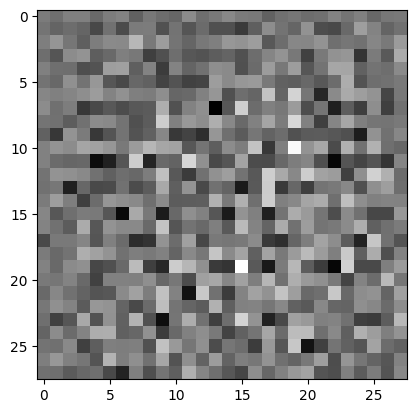

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### El discriminador

El discriminador es un clasificador de imágenes basado en CNN.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Utiliza el discriminador (aún sin entrenar) para clasificar las imágenes generadas como reales o falsas. El modelo se entrenará para generar valores positivos para las imágenes reales y valores negativos para las imágenes falsas.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00096287]], shape=(1, 1), dtype=float32)


## Definir la pérdida y los optimizadores

Definir las funciones de pérdida y los optimizadores para ambos modelos.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Pérdida del discriminador

Este método cuantifica la capacidad del discriminador para distinguir imágenes reales de falsas. Compara las predicciones del discriminador sobre imágenes reales con una matriz de 1, y las predicciones del discriminador sobre imágenes falsas (generadas) con una matriz de 0.


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Pérdida del generador
La pérdida del generador cuantifica su capacidad para engañar al discriminador. Intuitivamente, si el generador funciona bien, el discriminador clasificará las imágenes falsas como reales (o 1). Aquí, compare las decisiones del discriminador sobre las imágenes generadas con una matriz de 1.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Los optimizadores del discriminador y del generador son diferentes, ya que se entrenarán dos redes por separado.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Guardar puntos de control
Este cuaderno también muestra cómo guardar y restaurar modelos, lo que puede resultar útil en caso de que se interrumpa una tarea de entrenamiento de larga duración.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Definir el ciclo de entrenamiento

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El ciclo de entrenamiento comienza cuando el generador recibe una semilla aleatoria como entrada. Esa semilla se utiliza para producir una imagen. A continuación, se utiliza el discriminador para clasificar las imágenes reales (extraídas del conjunto de entrenamiento) y las imágenes falsas (producidas por el generador). Se calcula la pérdida para cada uno de estos modelos y se utilizan los gradientes para actualizar el generador y el discriminador.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generar y guardar imágenes**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Entrenar el modelo
Llama al método `train()` definido anteriormente para entrenar el generador y el discriminador simultáneamente. Ten en cuenta que entrenar GAN puede ser complicado. Es importante que el generador y el discriminador no se dominen entre sí (por ejemplo, que se entrenen a un ritmo similar).

Al comienzo del entrenamiento, las imágenes generadas parecen ruido aleatorio. A medida que avanza el entrenamiento, los dígitos generados se verán cada vez más reales. Después de unas 50 épocas, se asemejan a los dígitos MNIST. Esto puede tardar aproximadamente un minuto por época con la configuración predeterminada en Colab.

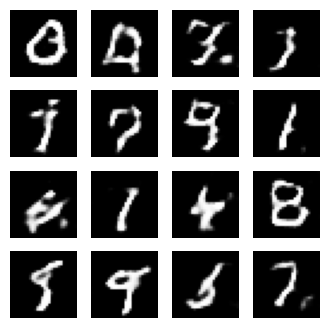

Time for epoch 32 is 11.874475240707397 sec


In [ ]:
train(train_dataset, EPOCHS)

Restaurar el último punto de control.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Crear un GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Utiliza `imageio` para crear un gif animado utilizando las imágenes guardadas durante el entrenamiento.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Próximos pasos

Este tutorial ha mostrado el código completo necesario para escribir y entrenar una GAN. Como siguiente paso, es posible que desee experimentar con un conjunto de datos diferente, por ejemplo, el conjunto de datos Large-scale Celeb Faces Attributes (CelebA) [disponible en Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). Para obtener más información sobre las GAN, consulta el [Tutorial NIPS 2016: Redes generativas adversarias](https://arxiv.org/abs/1701.00160).

# Preguntas

1. ¿Qué modelo preentrenado usamos para extraer características en el estilo y contenido?
2. ¿Qué imagen se utiliza para conservar el contenido en el estilo transfer?
3. ¿Qué imagen se utiliza para aportar el estilo?
4. ¿Qué representa la “imagen generada” en el proceso?
5. ¿Qué tipo de red es VGG19: de clasificación, regresión o segmentación?
6. ¿Qué función tiene PyTorch Lightning en el laboratorio?
7. ¿Qué tipo de operación usamos para medir la diferencia entre el estilo de dos imágenes?
8. ¿Qué función cumple la pérdida (loss) durante el entrenamiento?
9. ¿Por qué debemos redimensionar las imágenes antes de usarlas en el modelo?
10. ¿Qué ocurre al aumentar el peso del estilo en la función de pérdida: se ve más el contenido o más el estilo?